In [1]:
# -*- coding: utf-8 -*- 

import os
import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib
import nilearn as nil

from bids import BIDSLayout
from tqdm import tqdm

import pickle
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import zscore

from nltools.external import glover_hrf

import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# information for path, hyperparams..
cfg = {
    'data_dir': Path('/home/mybirth0407/datasets/ds000005'), # custom directory
    'response_tr': 0.01, # for spike generator resolution
    'hrf_convolution_span': 30
}

In [3]:
layout = BIDSLayout(cfg['data_dir'], derivatives=True)

# if data_dir not include derivatives files
# layout.add_derivatives(DERIVATIVES_PATH)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [4]:
# make config
image_sample = nib.load(
    layout.derivatives['fMRIPrep'].get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='bold',
        extension='nii.gz'
        )[0])

cfg['time_dimension'] = image_sample.shape[3] # nii.gz file's 4th position element is time dimension, (x, y, z, t)
cfg['time_indices'] = [t for t in range(0, int(cfg['time_dimension'] * layout.get_tr() / cfg['response_tr']), int(1 / cfg['response_tr']))] # time slicing 1 per 100ms
cfg['affine'] = image_sample.affine # for resampling

In [5]:
layout.get(target='run', return_type='id')

d = {
    'subjID': np.array([[subject] * len(layout.get(target='run', return_type='id')) for subject in layout.get(target='subject', return_type='id')]).flatten(),
    'run': np.array([run for run in layout.get(target='run', return_type='id')] * len(layout.get(target='subject', return_type='id'))).flatten(),
    'nii_filepath': sorted(layout.derivatives['fMRIPrep'].get(return_type='file', suffix='bold', extension='nii.gz')),
    'events_filepath': sorted(layout.get(return_type='file', suffix='events', extension='tsv')),
}

df_subject_run = pd.DataFrame(d)
df_subject_run.head()

,subjID,run,nii_filepath,events_filepath
0,01,1,/home/mybirth0407/datasets/ds000005/derivative...,/home/mybirth0407/datasets/ds000005/sub-01/fun...
1,01,2,/home/mybirth0407/datasets/ds000005/derivative...,/home/mybirth0407/datasets/ds000005/sub-01/fun...
2,01,3,/home/mybirth0407/datasets/ds000005/derivative...,/home/mybirth0407/datasets/ds000005/sub-01/fun...
3,02,1,/home/mybirth0407/datasets/ds000005/derivative...,/home/mybirth0407/datasets/ds000005/sub-02/fun...
4,02,2,/home/mybirth0407/datasets/ds000005/derivative...,/home/mybirth0407/datasets/ds000005/sub-02/fun...


In [6]:
df_events = []

for i, row in df_subject_run.iterrows():
    df = pd.read_table(row['events_filepath'])
    df['subjID'] = row['subjID']
    df['run'] = row['run']
    df_events.append(df)

df_events = pd.concat(df_events)

In [7]:
df_events = df_events[df_events['respcat'] != -1]
df_events['onset'] = df_events['onset'].astype(np.int)
df_events['cert'] = 0 # certain..?
df_events['gamble'] = df_events['respcat']

columns = df_events.columns.copy() # for safety
df_events.head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,01,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,01,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,01,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,01,1,0,1
5,28,3,0.0273,-0.4147,0.011,26,13,13.13,2,1,1.232,01,1,0,1


In [8]:
model = ra_prospect(data=df_events, ncore=4)
print(model.all_ind_pars)
params = model.all_ind_pars
params.to_csv('models/ra_prospect_params.tsv', sep='\t', index=False)

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl

Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 16
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/hbayesdm/base.py:447: RuntimeWarning: Failed to get VB estimates for initial values. Use random values for initial values.
  RuntimeWarning, stacklevel=1)


Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'subjid', 'run', 'cert', 'gamble'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'subjID', 'run', 'cert', 'gamble']
************************************
**** Model fitting is complete! ****
************************************
         rho    lambda        tau
01  0.452779  1.020765  17.503779
02  0.357348  1.450019  17.606193
03  0.296477  1.423037  17.124479
04  0.293533  1.400937  17.207705
05  0.234816  1.236409  16.694432
06  0.317436  1.243105  17.102392
07  0.315350  1.076579  17.085963
08  0.403024  1.148925  17.347921
09  0.282328  1.327304  17.059212
10  0.445020  1.106335  17.452938
11  0.494329  1.015989  17.683299
12  0.348543  1.210045  17.284672
13  0.297482  1.360635  17.

In [9]:
params = pd.read_table('models/ra_prospect_params.tsv')
params['subjID'] = params.index + 1
params['subjID'] = params['subjID'].apply(lambda x: f'{x:02d}')

In [10]:
params.head()

,rho,lambda,tau,subjID
0,0.452779,1.020765,17.503779,01
1,0.357348,1.450019,17.606193,02
2,0.296477,1.423037,17.124479,03
3,0.293533,1.400937,17.207705,04
4,0.234816,1.236409,16.694432,05


In [11]:
try: 
    df_X = pd.merge(df_events, params, how='left', on=['subjID'])
except:
    df_events.columns = columns
    df_X = pd.merge(df_events, params, how='left', on=['subjID'])

# calculate for utility risky
df_X['U_risky'] = (df_X['gain'] ** df_X['rho']) - (df_X['lambda'] * (df_X['loss'] ** df_X['rho']))

In [12]:
def hrf_convolution(utilities, time_stamp, tr, config, hrf=glover_hrf(0.01, oversampling=1)):
    assert len(utilities) == len(time_stamp)
    
    output = np.zeros(int(tr * config['time_dimension'] / config['response_tr']))
    
    # make data impulse
    for time, value in zip(time_stamp, utilities):
        output[int(time / config['response_tr'])] = value
        
    # hrf convolution
    return output, np.convolve(output, hrf, mode='same')

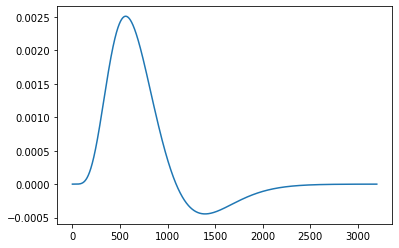

In [13]:
plt.plot(glover_hrf(0.01, oversampling=1))

In [14]:
dict_impulse_bold = {}

for name, group in tqdm(df_X.groupby(['subjID', 'run'])):
    subject_id, run = name[0], name[1]
    
    impulse, bold = hrf_convolution(
        group['U_risky'].to_numpy(),
        group['onset'].to_numpy(),
        layout.get_tr(),
        cfg
    )
    
    if subject_id not in dict_impulse_bold.keys():
        dict_impulse_bold[subject_id] = {run: {'impulse': impulse, 'bold': bold}}
    else:
        dict_impulse_bold[subject_id].update({run: {'impulse': impulse, 'bold': bold}})

100%|██████████| 48/48 [00:07<00:00,  6.59it/s]


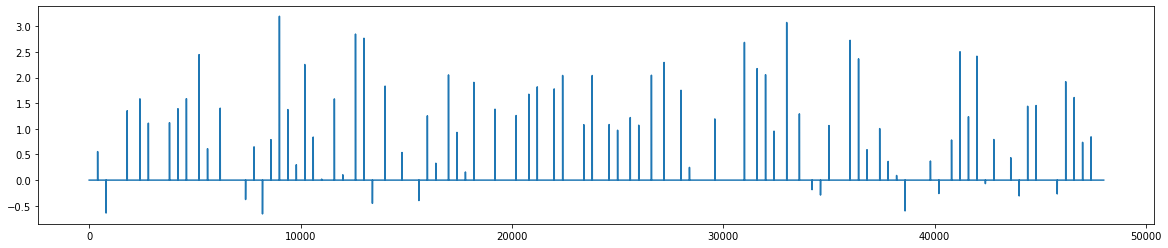

In [15]:
plt.figure(figsize=(20,4))
view_impulse = dict_impulse_bold['01'][1]['impulse']
plt.plot(view_impulse)

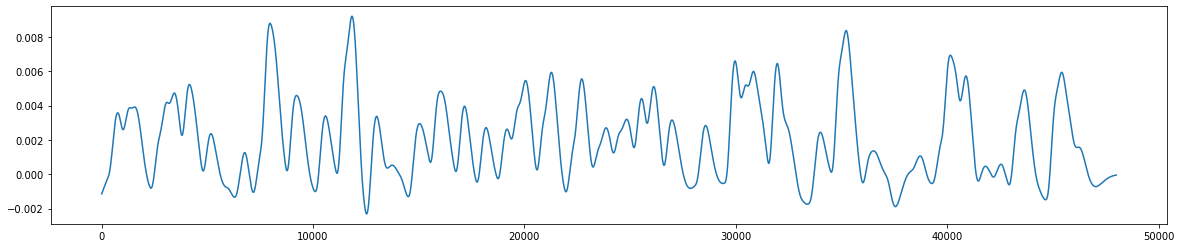

In [16]:
plt.figure(figsize=(20,4))
view_bold = dict_impulse_bold['01'][1]['bold']
plt.plot(view_bold)

In [17]:
train = {}
unit_time_length = int(layout.get_tr() / cfg['response_tr'])

for i, row in tqdm(df_subject_run.iterrows()):
    X, y = [] ,[]
    
    image = nib.load(row['nii_filepath']).get_fdata()
    time_length = image.shape[-1]
    
    x = dict_impulse_bold[row['subjID']][row['run']]['bold']
    x_desired_length = len(x) // unit_time_length
    x = x[: x_desired_length * unit_time_length]
    
    final_length = min(time_length, x_desired_length)
    
    x = x.reshape(-1, unit_time_length).mean(-1)[:final_length] 
    image = image[..., : final_length]
    X.append(np.array(x))
    
    if row['subjID'] not in train.keys():
        train[row['subjID']] = {
            'X': np.concatenate(X, -1),
            'y': image
        }
    else:
        train[row['subjID']]['X'] = np.append(train[row['subjID']]['X'], np.concatenate(X, -1))
        train[row['subjID']]['y'] = np.append(train[row['subjID']]['y'], image, axis=3)

48it [01:25,  1.79s/it]


In [18]:
with open('train.pkl', 'wb') as fp:
    pickle.dump(train, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('train.pkl', 'rb') as fp:
    train = pickle.load(fp)

In [20]:
print(train['01']['X'].shape, train['01']['y'].shape)

(720,) (63, 74, 49, 720)


In [21]:
coefs = {}

for key, value in tqdm(train.items()):
    X = value['X']
    y = value['y']
    coef = []
    
    for i in range(y.shape[0]):
        i_v = []
        for j in range(y.shape[1]):
            j_v = []
            for k in range(y.shape[2]):
                reg = LinearRegression().fit(X.reshape(-1, 1), y[i, j, k, :])
                j_v.append(float(reg.coef_))
            i_v.append(j_v)
        coef.append(i_v)
    coefs[key] = np.array(coef)

100%|██████████| 16/16 [19:04<00:00, 71.51s/it]


In [22]:
with open('linearregression_coefs.pkl', 'wb') as fp:
    pickle.dump(coefs, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('linearregression_coefs.pkl', 'rb') as fp:
    coefs = pickle.load(fp)

In [24]:
np.array(coefs['01']).shape

(63, 74, 49)

In [25]:
anat = layout.get(
            subject=layout.get(target='subject', return_type='id')[0],
            return_type='file',
            suffix='T1w',
            extension='nii.gz')
print(anat)

['/home/mybirth0407/datasets/ds000005/derivatives/fmriprep/sub-01/anat/sub-01_desc-preproc_T1w.nii.gz', '/home/mybirth0407/datasets/ds000005/derivatives/fmriprep/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz', '/home/mybirth0407/datasets/ds000005/sub-01/anat/sub-01_T1w.nii.gz']


In [26]:
anat_filepath = anat[1]

In [27]:
img = np.array(coefs['01'])
img = zscore(img)

In [28]:
img = nib.Nifti1Image(img, cfg['affine'])

In [29]:
from nilearn.image import resample_to_img
from nilearn.image import load_img

template = load_img(anat_filepath)
resampled_stat_img = resample_to_img(img, template)

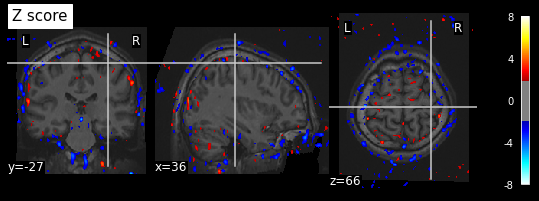

In [30]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(resampled_stat_img, bg_img=template,
              cut_coords=(36, -27, 66),
              threshold=2, title="Z score")
show()